### References

[1] Stereo signal separation and upmixing by mid-side decomposition in the frequency-domain

[2] Virtual sound source positioning using vector base amplitude panning

In [1]:
from math import pi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wavio
import IPython

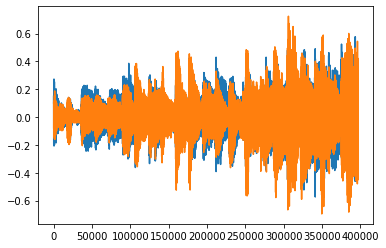

In [2]:
file = wavio.read("Open_Goldberg_Variatio_18a1-stereo.wav")
fixed_data0 = file.data[:, 0]
fixed_data1 = file.data[:, 1]
data0 = fixed_data0.astype(np.float32, order='C') / 32767.0
data1 = fixed_data1.astype(np.float32, order='C') / 32767.0

data0 = data0[44100:441000]
data1 = data1[44100:441000]

plt.plot(data0)
plt.plot(data1)
plt.show()

In [3]:
def PreProcessData(xn, frameSize, stepSize):
    xn = np.append(np.zeros(128), xn)
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    iteration = (len(temp) // stepSize) - (frameSize // stepSize) + 1
    
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = temp[start:end]
        
    return dataSet, temp, len(temp), iteration

In [4]:
M = 2048
H = 128
FS = 1
FA = 1
RA = 1
W_unnormalized = signal.get_window("hamming", M)
W = W_unnormalized / sum(W_unnormalized)

dataSet0, data0, length, iteration = PreProcessData(data0, M, H)
dataSet1, data1, length, iteration = PreProcessData(data1, M, H)

width = np.exp(np.pi * 0.6 * np.complex128(1j))
rms = np.sqrt(2) / 2
minimum  = 2.2250738585072014e-308

In [5]:
DIRECT = np.zeros(length)
DL = np.zeros(length)
DR = np.zeros(length)
DC = np.zeros(length)
NL = np.zeros(length)
NR = np.zeros(length)

aL_prev = np.zeros(M)
aR_prev = np.zeros(M)

for index in range(iteration):
    
    fL = np.fft.fft(dataSet0[index] * W)
    fR = np.fft.fft(dataSet1[index] * W)
    
    distance = np.sqrt( np.abs(fL) ** 2 + np.abs(fR) ** 2)
    
    aL = np.abs(fL) / (distance + minimum)
    aR = np.abs(fR) / (distance + minimum)

    direct = np.zeros(M, dtype = np.complex128)
    dc_mag = np.zeros(M, dtype = np.complex128)
    dl =     np.zeros(M, dtype = np.complex128)
    dr =     np.zeros(M, dtype = np.complex128)
    nl =     np.zeros(M, dtype = np.complex128)
    nr =     np.zeros(M, dtype = np.complex128)
    dc =     np.zeros(M, dtype = np.complex128)
    cl =     np.zeros(M, dtype = np.complex128)
    cr =     np.zeros(M, dtype = np.complex128)
    
    direct = (fL * width - fR) / (aL * width - aR + minimum)
    
    dl = direct * aL
    dr = direct * aR
    
    dc_mag = rms * ( np.abs(dl + dr) - np.abs(dl - dr))

    dc = ((dl + dr) * dc_mag) / (np.abs(dl + dr) + minimum)
    cl = dl - dc * rms
    cr = dr - dc * rms
    nl = fL - dl
    nr = fR - dr

    temp0 = np.fft.ifft(direct).real * W
    temp1 = np.fft.ifft(fL).real * W
    temp2 = np.fft.ifft(fR).real * W
    temp3 = np.fft.ifft(dc).real * W
    temp4 = np.fft.ifft(nl).real * W
    temp5 = np.fft.ifft(nr).real * W
    
    start = index * H
    end = start + M
    
    DIRECT[start:end] = DIRECT[start:end] + temp0
    DL[start : end] = DL[start : end] + temp1
    DR[start : end] = DR[start : end] + temp2
    DC[start : end] = DC[start : end] + temp3
    NL[start : end] = NL[start : end] + temp4
    NR[start : end] = NR[start : end] + temp5

In [6]:
wavio.write("DIRECT.wav", DIRECT, file.rate, sampwidth=3)
wavio.write("DL.wav", DL, file.rate, sampwidth=3)
wavio.write("DR.wav", DR, file.rate, sampwidth=3)
wavio.write("DC.wav", DC, file.rate, sampwidth=3)
wavio.write("NL.wav", NL, file.rate, sampwidth=3)
wavio.write("NR.wav", NR, file.rate, sampwidth=3)

IPython.display.display(IPython.display.Audio("DIRECT.wav", rate=file.rate))
IPython.display.display(IPython.display.Audio("DL.wav", rate=file.rate))
IPython.display.display(IPython.display.Audio("DR.wav", rate=file.rate))
IPython.display.display(IPython.display.Audio("DC.wav", rate=file.rate))
IPython.display.display(IPython.display.Audio("NL.wav", rate=file.rate))
IPython.display.display(IPython.display.Audio("NR.wav", rate=file.rate))